# Description

we thought that a good baseline to start with was to build a model from scratch using the example from keras:<br>
http://keras.io/examples/vision/image_classification_from_scratch/ <br>

we did this in order to see what could be improved from it


# Import

In [3]:
import numpy as np
import pandas as pd
import os
import shutil
import keras
from google.colab import drive
from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import RandAugment
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

In [13]:
# if using colab, run this cell to import the data
from google.colab import drive
import zipfile
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/rare_species 1.zip'
extract_path = '/content/rare_species 1'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# With colab
folder_path = '/content/rare_species 1'
meta = pd.read_csv('/content/rare_species 1/metadata.csv')

# With vscode
# folder_path = '../data/rare_species 1'
# meta = pd.read_csv('../data/rare_species 1/metadata.csv')

# Data Preparation

## Data Split

In [15]:
image_size = (224, 224)
seed = 42
batch_size = 64

train_ds, val_ds= keras.utils.image_dataset_from_directory(
    folder_path,
    validation_split=0.2,
    subset= "both",
    seed= seed,
    image_size= image_size,
    batch_size= batch_size
)

Found 11983 files belonging to 202 classes.
Using 9587 files for training.
Using 2396 files for validation.


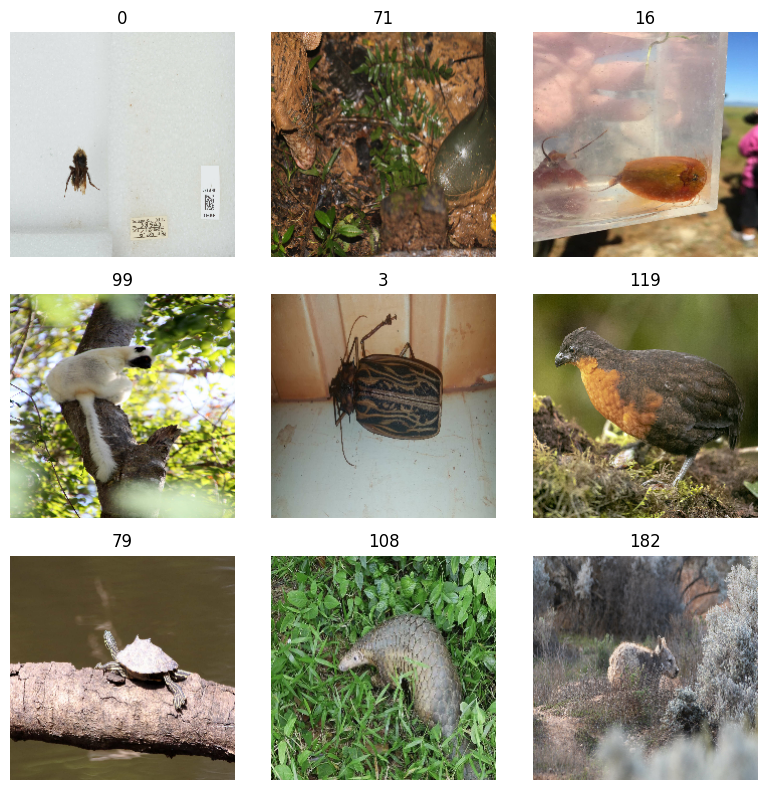

In [16]:
def display_images(train_ds):
    for images, labels in train_ds.take(1):
        plt.figure(figsize=(8, 8))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")
        plt.tight_layout()
        plt.show()

display_images(train_ds)

## Augmentation layer

We decided to use the RandAugment layer from Keras because it is an all-in-one method. Although it may be refined in future iterations, for now it simplifies our process by establishing a solid starting point for further improvements.

In [17]:
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

data_augmentation_layers = [
    layers.RandAugment(value_range=(0, 255))
 ## add any you want here
]

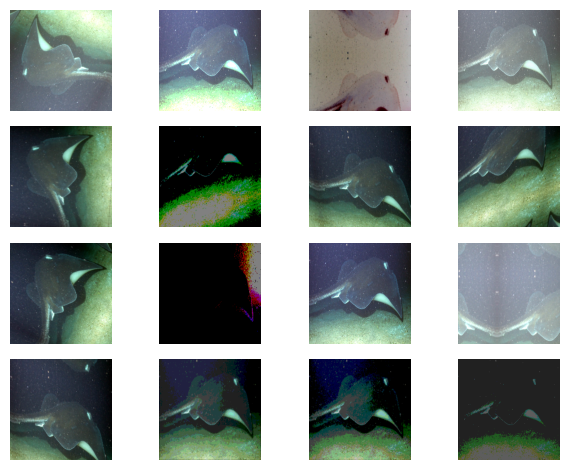

In [18]:
## plot the result of augmentation layer
for images, _ in train_ds.take(1):

    for i in range(16):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Model building
Must instal:

python3.11 -m pip install pydot

brew install graphviz


This is roughly the same model provided in the example give or take some minor changes
- The output changed to fit a multiclassification purpose
- We added the augmentation layer in the pipeline

In [19]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Apply data augmentation
    x = data_augmentation(inputs)
    # Add a Rescaling layer
    x = layers.Rescaling(1.0 / 255)(x)

    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)


    outputs = layers.Dense(num_classes, activation="softmax")(x) # as we deal with a lot of classes
    return keras.Model(inputs, outputs)

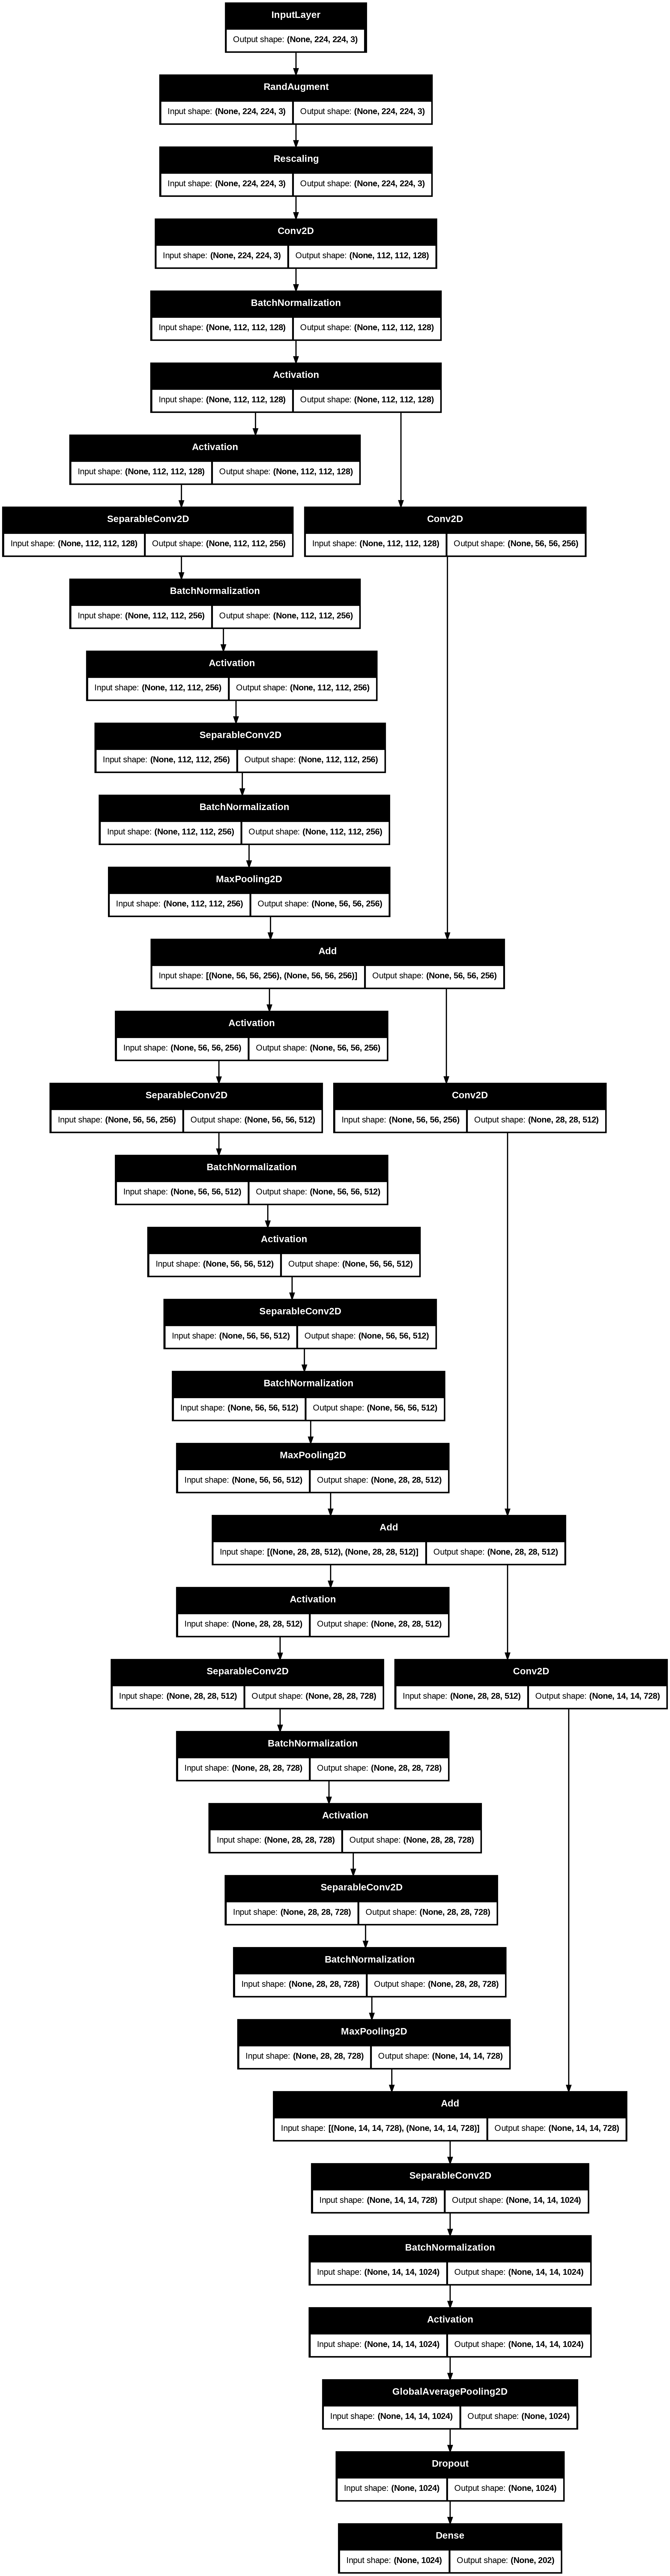

In [20]:
model= make_model(input_shape=image_size + (3,), num_classes=202)
keras.utils.plot_model(model, show_shapes=True)

## model run

- we decided to add something to update the learning rate as we saw in class
- we decided to keep only the best model from the run therefore changing the original callbacks from the example
- we decided to save the model that gave the best level of accuracy on val

In [21]:
epochs = 25

# make the learning rate change over the epochs to avoid getting stuck
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.95
)

callbacks = [
    # saves the best model of the run using max val_accuracy as a metric
    keras.callbacks.ModelCheckpoint(
        "best_model_example.keras",
        save_best_only=True,
        monitor="val_acc", # the best model to be save is the in that has the best score in accuracy for the validation set
        mode="max",
        verbose=1)
    ]

## change from kera example is the loss function as we deal with a lot of classes
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm= 1.0), ## clipnorm added to avoid nan in the loss
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## change this CategoricalCrossentropy to the the one it is now
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")], ## change this CategoricalCrossentropy to the the one it is now
 ## added to avoid nan in the loss
)

model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

# get the clasification report
best_model_example = keras.models.load_model("best_model_example.keras")
y_pred_probs = best_model_example.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in val_ds], axis=0)

print(classification_report(y_true, y_pred))

Epoch 1/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.0561 - loss: 5.1055
Epoch 1: val_acc improved from -inf to 0.02713, saving model to best_model_example.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - acc: 0.0562 - loss: 5.1044 - val_acc: 0.0271 - val_loss: 5.2758
Epoch 2/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.0915 - loss: 4.6621
Epoch 2: val_acc improved from 0.02713 to 0.03464, saving model to best_model_example.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - acc: 0.0914 - loss: 4.6621 - val_acc: 0.0346 - val_loss: 5.2380
Epoch 3/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.0964 - loss: 4.5475
Epoch 3: val_acc improved from 0.03464 to 0.04215, saving model to best_model_example.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - acc: 0.0963 - loss: 4.5475 - val_acc: 0.0422 - val_loss: 5.2025
Epoch 4/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.1083 - loss: 4.4501
Epoch 4: val_acc improved from 0.04215 to 0.04800, saving model to best_model_examp

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Conclusion

- From the EDA, we observed a large number of classes. Given this, it's likely difficult to train a single model effectively across all classes. One possible solution is to split the training process by *phylum*, training separate models for each group. For one phylum that contains only a single class, training a model is unnecessary.

- Another possible source of performance issues is the model architecture itself, as we are currently training it from scratch. A simple and effective alternative would be to use a pretrained model and fine-tune its weights to better fit our problem. This approach may require a higher learning rate due to the design of the pretrained model.

- The data, as shown in the EDA, is significantly imbalanced. A simple strategy to address this is to apply oversampling to underrepresented classes.

- Upon manual inspection of the dataset, some images appear to be mislabeled or inconsistent with their class (e.g., a class labeled as "frogs" also includes images of baby frogs, which look quite different). These inconsistencies may introduce noise into the training process, and manually cleaning such cases could lead to better model performance.

- The preprocessing pipeline used so far is quite basic and will likely need to be improved in future iterations to better suit the complexity of the problem.
